### Environment Setup

First we must setup our environment to make sure we have all appropriate
modules installed. To do this install all
modules using a .yaml file via conda .
To do this, run:
conda env create -f env_setup/project_env.yml
Then activate the environment by:
conda activate data_env

### Data Importing and Pre-processing

In [32]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from scipy.stats import probplot
from sklearn.preprocessing import RobustScaler
from scipy.stats import norm, probplot, skew
import numpy as np
from sklearn import preprocessing


In [33]:
df = pd.read_csv('diabetes_prediction_dataset.csv')
df

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0
...,...,...,...,...,...,...,...,...,...
99995,Female,80.0,0,0,No Info,27.32,6.2,90,0
99996,Female,2.0,0,0,No Info,17.37,6.5,100,0
99997,Male,66.0,0,0,former,27.83,5.7,155,0
99998,Female,24.0,0,0,never,35.42,4.0,100,0


In [34]:
total = df.isnull().sum().sort_values(ascending=False)
percent = (df.isnull().sum() / df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=["Total", "Percent"])
missing_data


,Total,Percent
gender,0,0.0
age,0,0.0
hypertension,0,0.0
heart_disease,0,0.0
smoking_history,0,0.0
bmi,0,0.0
HbA1c_level,0,0.0
blood_glucose_level,0,0.0
diabetes,0,0.0


As we can see based off of the fact that we have no null values for any of our columns we do not need to apply any sort of handling of our missing data. In this case if we were to have missing data for age, bmi, HbA1c_level, blood_glucose_level we would take the medium values inside of these columns and input that for the missing values as this is best practice in our case. However just because there is no null values, the smoking history column has a section that says no info

In [35]:
count = (df['smoking_history'] == 'No Info').sum()
print(count)

print(df['smoking_history'].value_counts())
print("Total people with diabetes", df['diabetes'].sum())


diabetes = ((df['diabetes'] == 1) & (df['smoking_history'] == 'No Info')).sum()
diabetes2 = ((df['diabetes'] == 0) & (df['smoking_history'] == 'No Info')).sum()
print(f"Number of 'No info' on smoking histroy with Diabetes: {diabetes}")
print(f"Number of 'No info' on smoking histroy without Diabetes: {diabetes2}")

35816
smoking_history
No Info        35816
never          35095
former          9352
current         9286
not current     6447
ever            4004
Name: count, dtype: int64
Total people with diabetes 8500
Number of 'No info' on smoking histroy with Diabetes: 1454
Number of 'No info' on smoking histroy without Diabetes: 34362


In [36]:
rows = len(df)

drop_percent = count/rows
drop_percent

np.float64(0.35816)

As can be seen by the 2 previous cells, the number of people that have diabetes with no info on their smoking history is about 17 percent of our total population of those that have diabetes. This brings into question what we should do with this column that has no info. 

<function matplotlib.pyplot.show(close=None, block=None)>

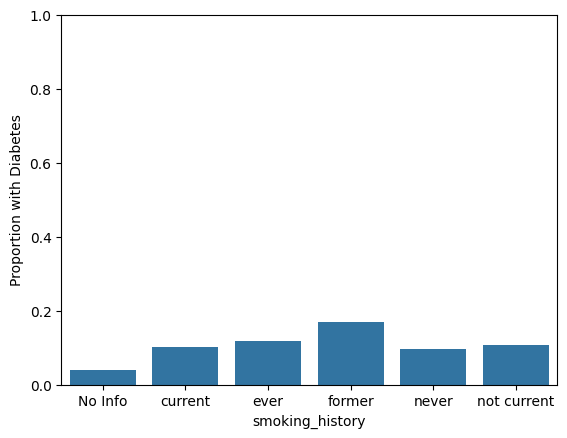

In [37]:
grouped = df.groupby('smoking_history')['diabetes'].mean().reset_index()

sns.barplot(x='smoking_history', y='diabetes', data=grouped)
plt.ylabel('Proportion with Diabetes')
plt.ylim(0,1)
plt.show

In [38]:
print("Number of 'No info' for smokers: ", (df['smoking_history'] == "No Info").sum())

Number of 'No info' for smokers:  35816


As you can see the no info on the smoking column for people with diabates is by far the lowest. However when we leave those rows in our model is almost 1.5% more accurate on unseen data. This is why we have devided to leave in theses rows for our project.

Here we can create a label encoder to encode all of our categorical data. This will correspond to not current smoker = 5, never smoked = 4, former smoker = 3, ever = 2, current smoker = 1, no info = 0

In [39]:
le = LabelEncoder()
df["smoking_encoded"] = le.fit_transform(df["smoking_history"])
encoded = le.fit_transform(df['smoking_encoded'])
df.head(15)

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes,smoking_encoded
0,Female,80.0,0,1,never,25.19,6.6,140,0,4
1,Female,54.0,0,0,No Info,27.32,6.6,80,0,0
2,Male,28.0,0,0,never,27.32,5.7,158,0,4
3,Female,36.0,0,0,current,23.45,5.0,155,0,1
4,Male,76.0,1,1,current,20.14,4.8,155,0,1
5,Female,20.0,0,0,never,27.32,6.6,85,0,4
6,Female,44.0,0,0,never,19.31,6.5,200,1,4
7,Female,79.0,0,0,No Info,23.86,5.7,85,0,0
8,Male,42.0,0,0,never,33.64,4.8,145,0,4
9,Female,32.0,0,0,never,27.32,5.0,100,0,4


We can also get rid of the gender category and dummy encode it, knowing that if we have 

In [40]:
df = pd.get_dummies(df, columns=["gender"], drop_first=True)
df.drop(columns=["gender_Other"], inplace=True)
df

,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes,smoking_encoded,gender_Male
0,80.0,0,1,never,25.19,6.6,140,0,4,False
1,54.0,0,0,No Info,27.32,6.6,80,0,0,False
2,28.0,0,0,never,27.32,5.7,158,0,4,True
3,36.0,0,0,current,23.45,5.0,155,0,1,False
4,76.0,1,1,current,20.14,4.8,155,0,1,True
...,...,...,...,...,...,...,...,...,...,...
99995,80.0,0,0,No Info,27.32,6.2,90,0,0,False
99996,2.0,0,0,No Info,17.37,6.5,100,0,0,False
99997,66.0,0,0,former,27.83,5.7,155,0,3,True
99998,24.0,0,0,never,35.42,4.0,100,0,4,False


The cell below demonstrates the lack of homogeniouty between our different categorical elements, with smoking_history having a ~.546 mode frequency, showing this could be a viable comparison for our model.

In [41]:
print("Categorical Columns Mode Frequency")
cat_columns = df.select_dtypes(include=["object"]).columns
mode_freq_df = pd.DataFrame(columns=["column_name", "mode_frequency"])
mode_freq_df.head
for col in cat_columns:
    mode_value = df[col].mode().iat[0]
    mode_freq = (df[col] == mode_value).mean()
# create a new row at the next integer index
mode_freq_df.loc[len(mode_freq_df)] = [col, mode_freq]
print(mode_freq_df.sort_values("mode_frequency", ascending=False).head(10))

Categorical Columns Mode Frequency
       column_name  mode_frequency
0  smoking_history         0.35816


---
Handling Outliers

In [42]:
df.head()

,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes,smoking_encoded,gender_Male
0,80.0,0,1,never,25.19,6.6,140,0,4,False
1,54.0,0,0,No Info,27.32,6.6,80,0,0,False
2,28.0,0,0,never,27.32,5.7,158,0,4,True
3,36.0,0,0,current,23.45,5.0,155,0,1,False
4,76.0,1,1,current,20.14,4.8,155,0,1,True


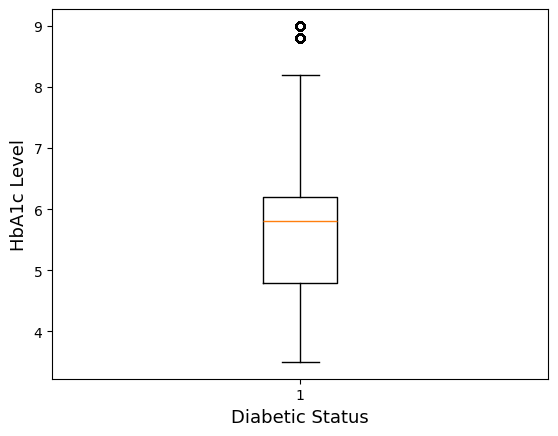

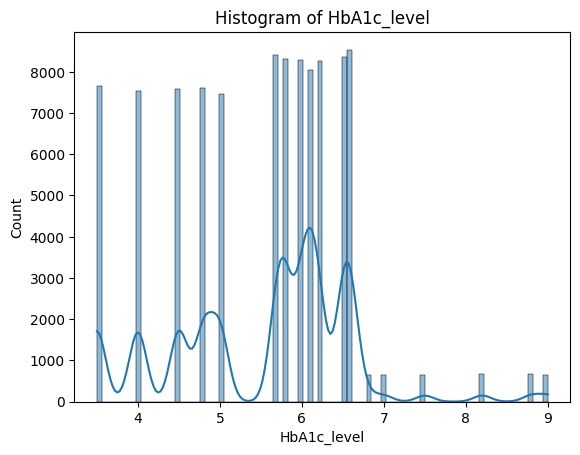

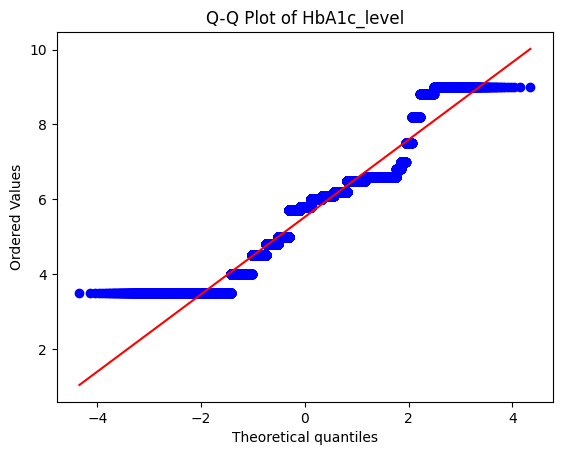

In [43]:
fig, ax = plt.subplots()
ax.boxplot(x=df["HbA1c_level"])
plt.ylabel("HbA1c Level", fontsize=13)
plt.xlabel("Diabetic Status", fontsize=13)
plt.show()
sns.histplot(df["HbA1c_level"], kde=True)
plt.title(f'Histogram of HbA1c_level')
plt.show()
probplot(df["HbA1c_level"], dist="norm", plot=plt)
plt.title(f'Q-Q Plot of HbA1c_level')
plt.show()

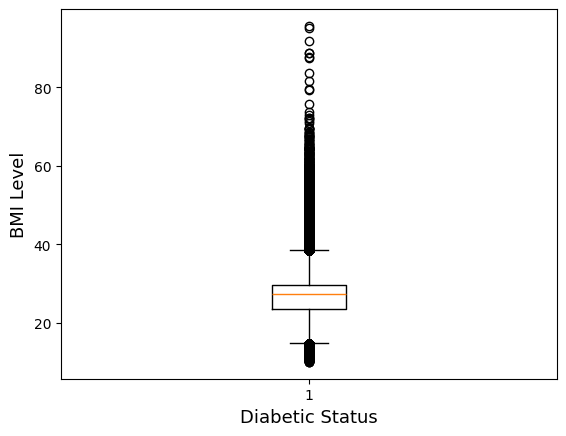

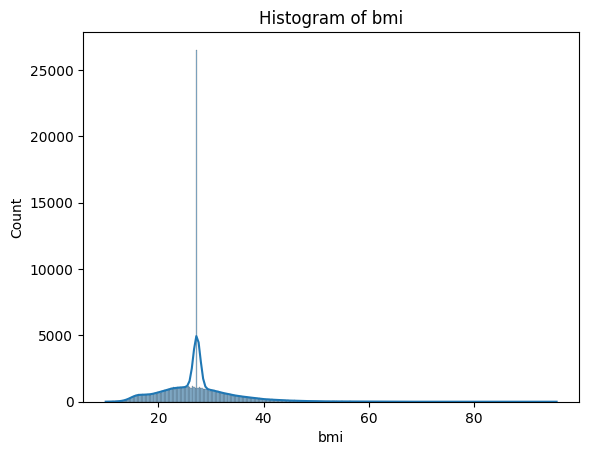

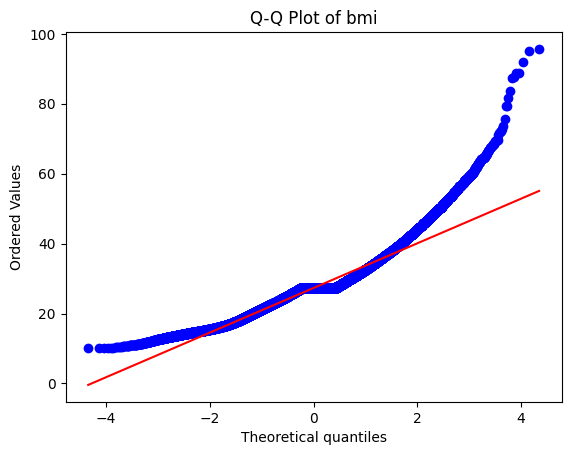

In [44]:
fig, ax = plt.subplots()
ax.boxplot(x=df["bmi"])
plt.ylabel("BMI Level", fontsize=13)
plt.xlabel("Diabetic Status", fontsize=13)
plt.show()
sns.histplot(df["bmi"], kde=True)
plt.title(f'Histogram of bmi')
plt.show()
probplot(df["bmi"], dist="norm", plot=plt)
plt.title(f'Q-Q Plot of bmi')
plt.show()

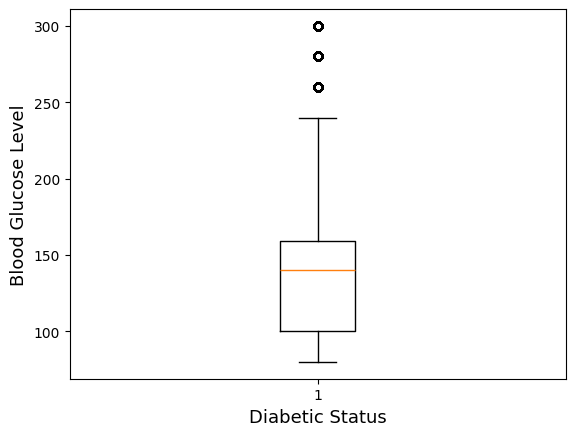

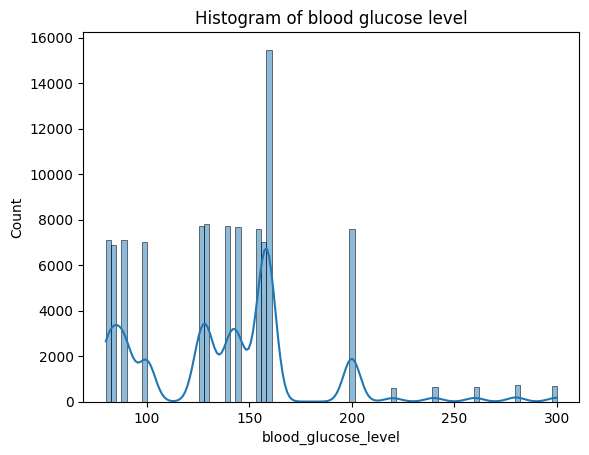

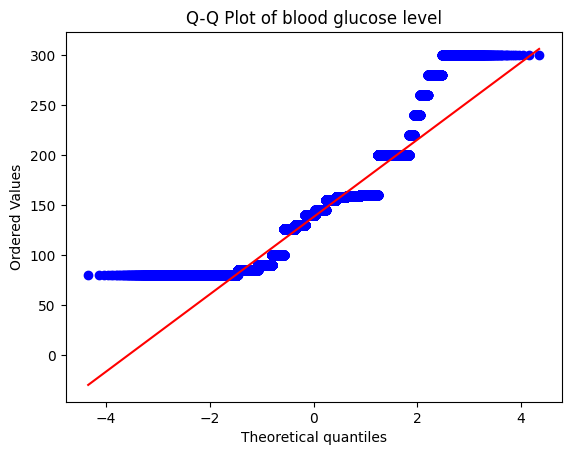

In [45]:

fig, ax = plt.subplots()
ax.boxplot(x=df["blood_glucose_level"])
plt.ylabel("Blood Glucose Level", fontsize=13)
plt.xlabel("Diabetic Status", fontsize=13)
plt.show()
sns.histplot(df["blood_glucose_level"], kde=True)
plt.title(f'Histogram of blood glucose level')
plt.show()
probplot(df["blood_glucose_level"], dist="norm", plot=plt)
plt.title(f'Q-Q Plot of blood glucose level')
plt.show()

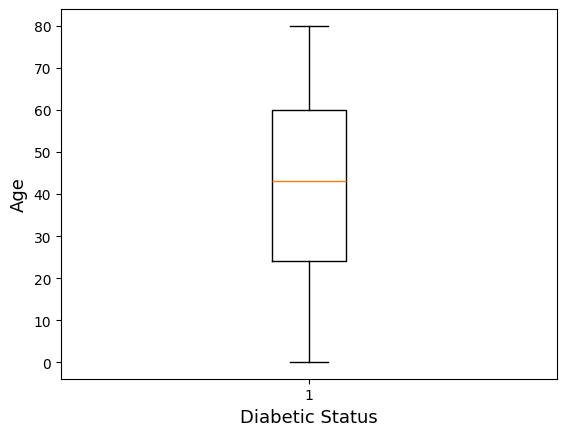

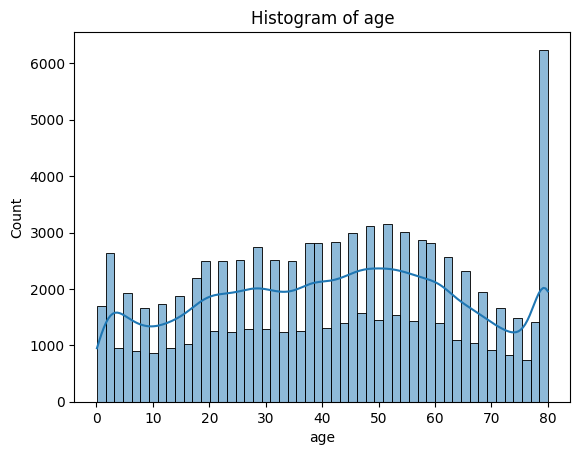

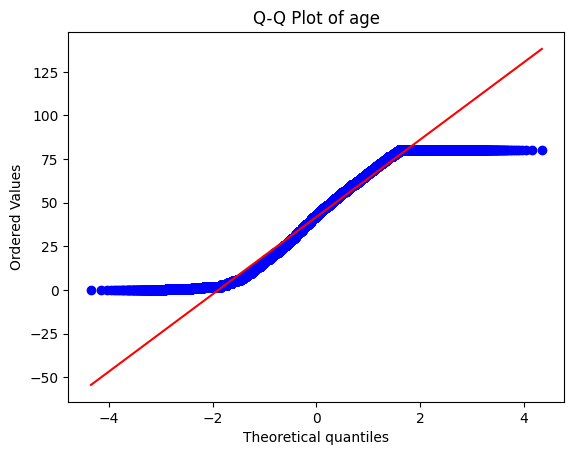

In [46]:
fig, ax = plt.subplots()
ax.boxplot(x=df["age"])
plt.ylabel("Age", fontsize=13)
plt.xlabel("Diabetic Status", fontsize=13)
plt.show()
sns.histplot(df["age"], kde=True)
plt.title(f'Histogram of age')
plt.show()
probplot(df["age"], dist="norm", plot=plt)
plt.title(f'Q-Q Plot of age')
plt.show()

As this data does have outliers throughout the features we are not going to get rid of those as they may be clinically significant. Through research we found that high HbA1c and high blood glucose level is often associated with diabetes, so we do not want to to get rid of this and lose accuracy of our model. We will preform normalization techniques on all these features as shown by the histrogram the data is no where near normal. This can also be seen by the qq plot as our data does not stick to the red line. We will use normalization technioques on the data and see how our models preforms and comapre it to scaled data to see which model preforms the best on what type of dataset. 


--- StandardScaler ---


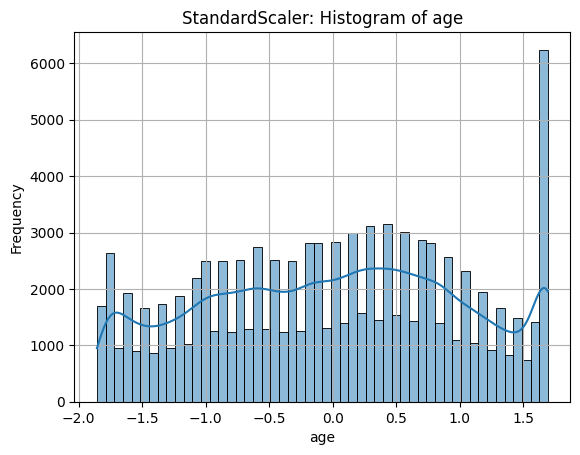

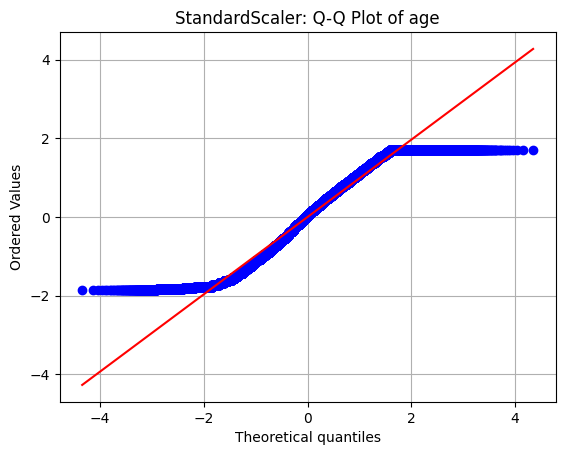

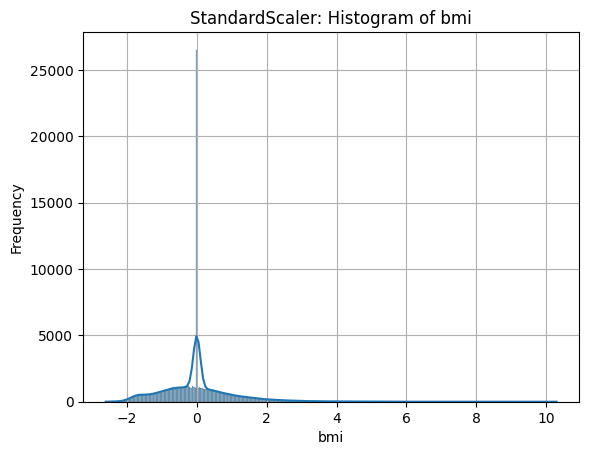

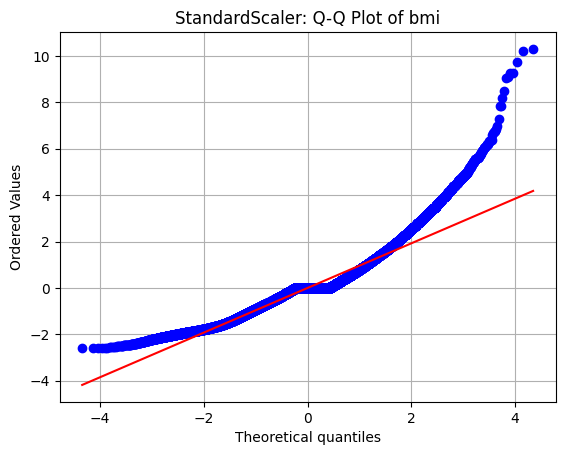

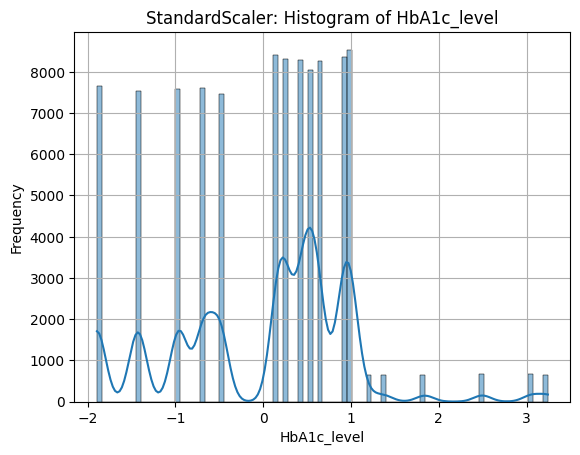

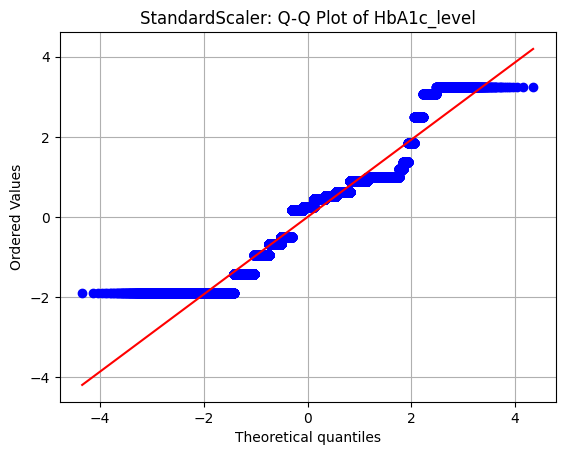

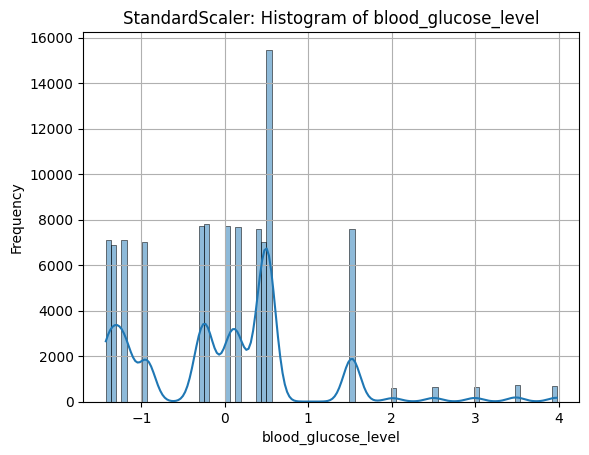

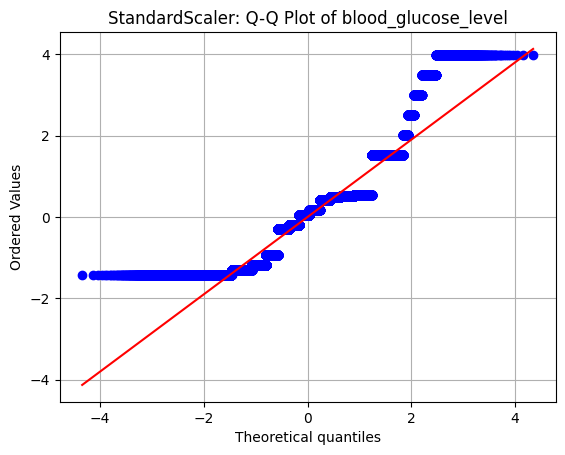

--- RobustScaler ---


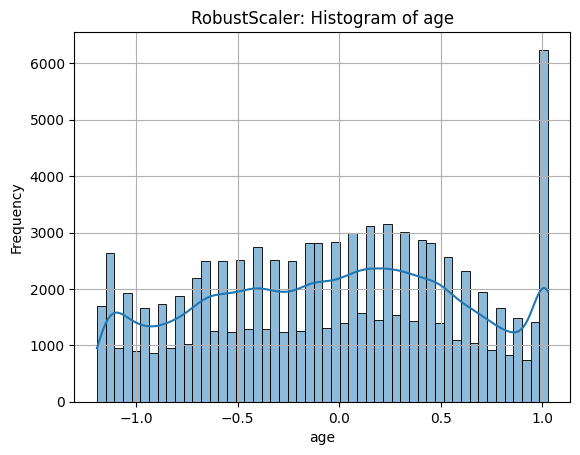

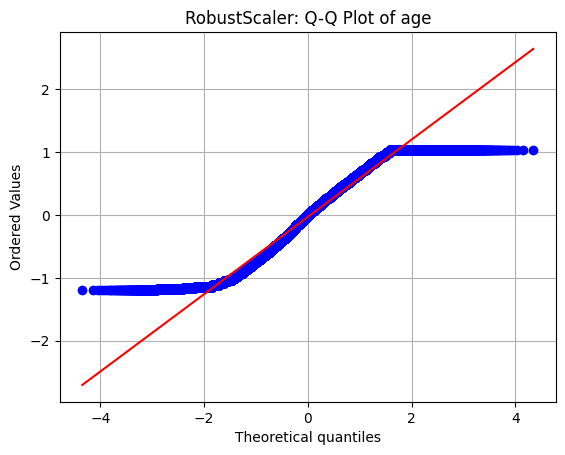

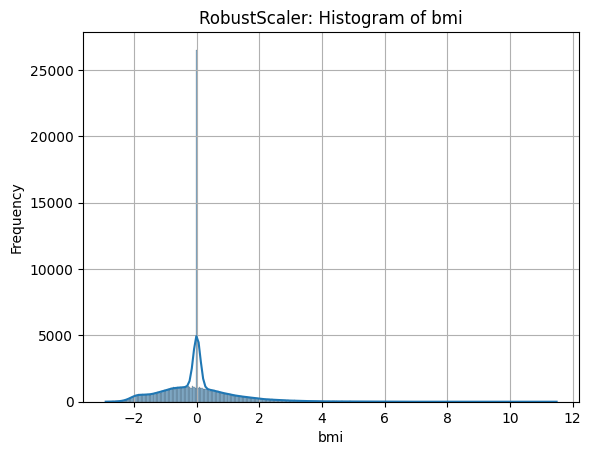

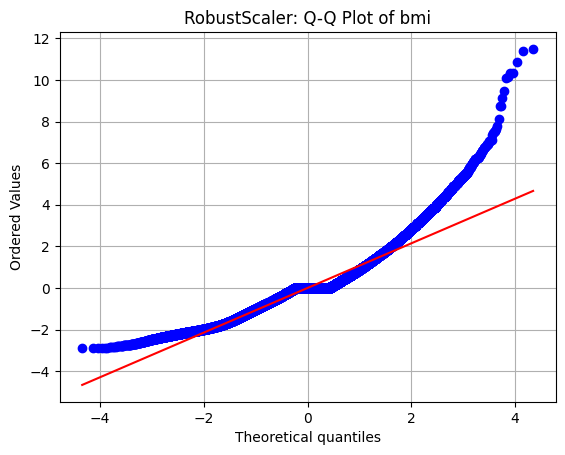

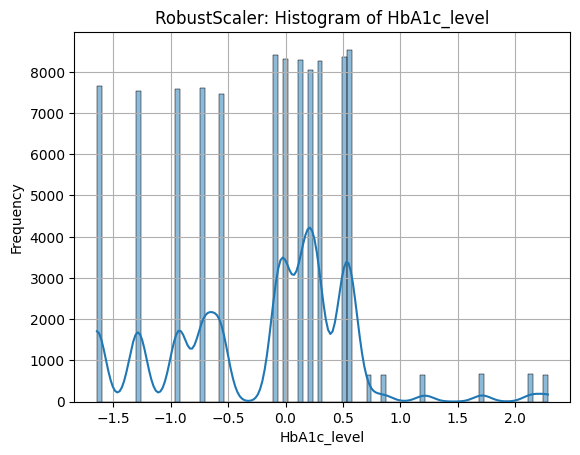

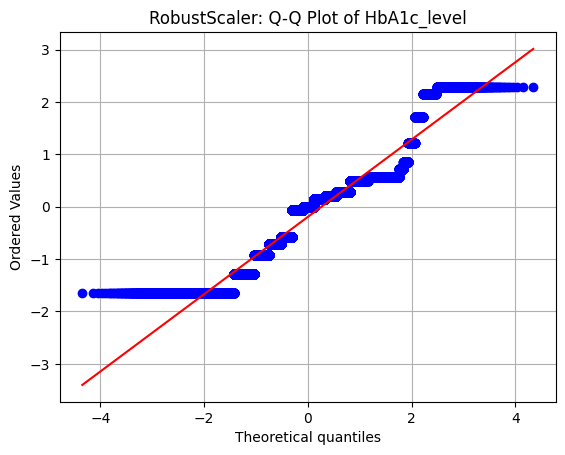

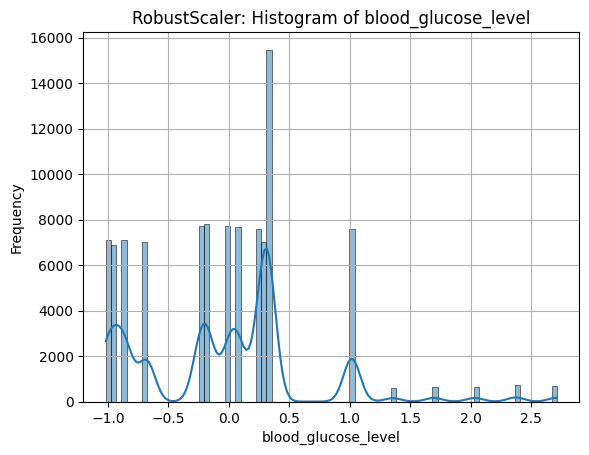

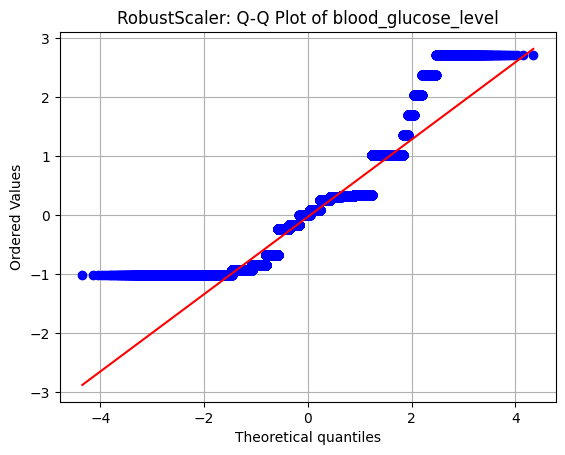

--- Normalizer ---


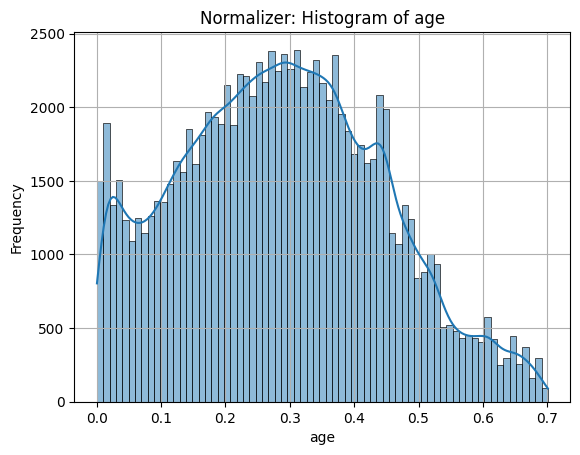

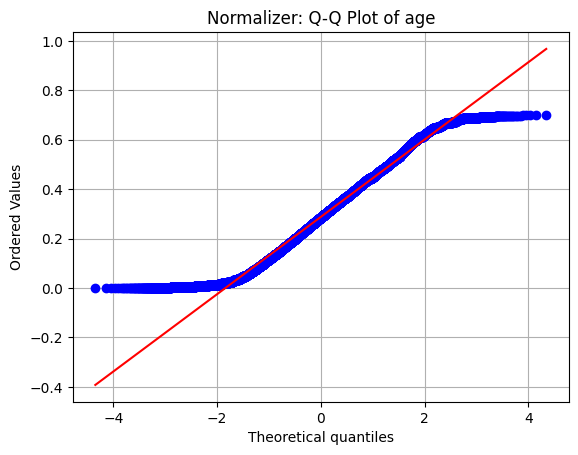

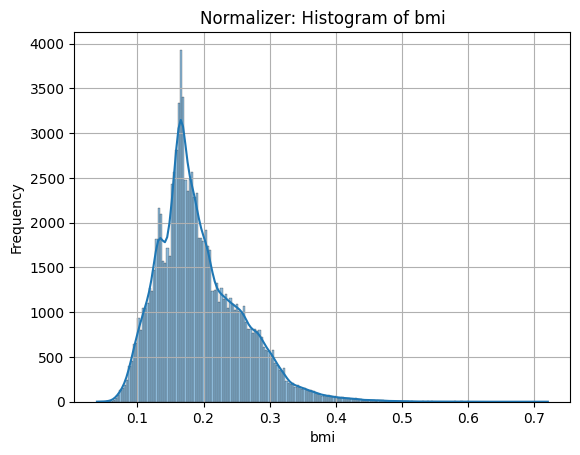

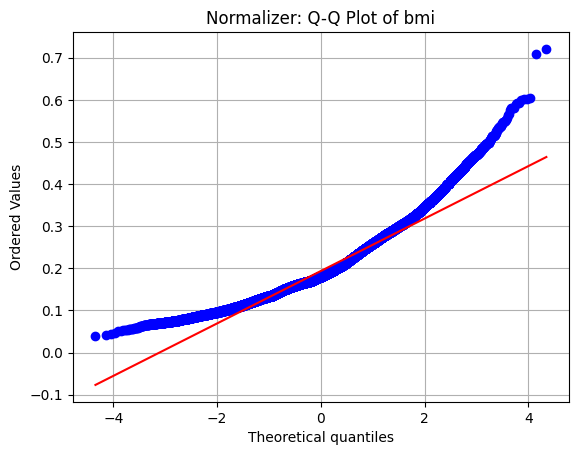

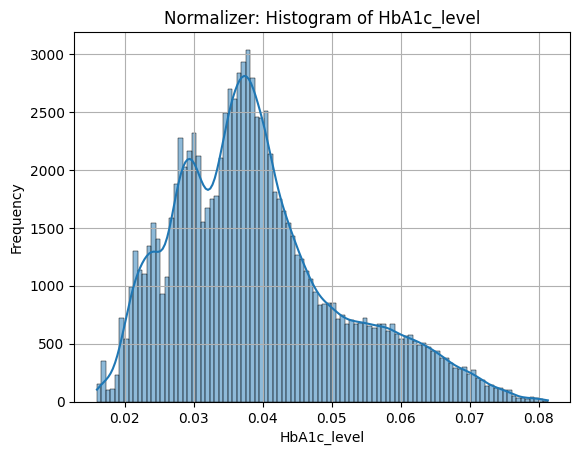

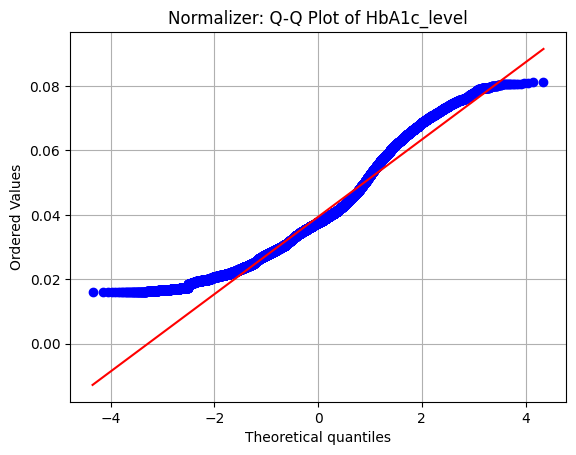

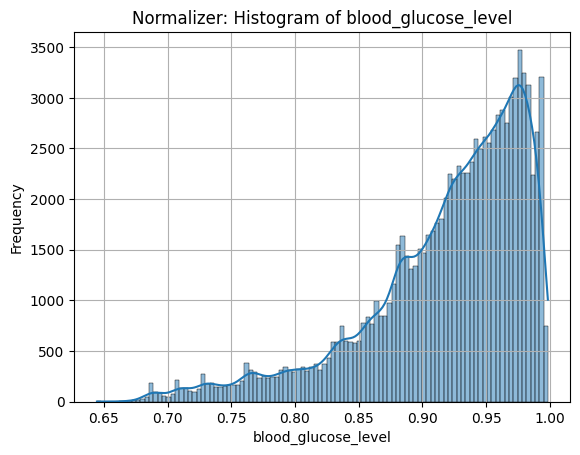

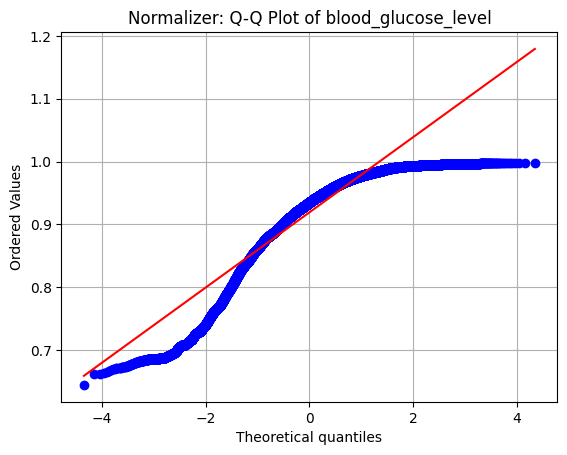

In [47]:

from sklearn.preprocessing import StandardScaler, Normalizer

num_cols = ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']

# Original data backup
df_original = df.copy()

# Dictionary of scalers to apply
scalers = {
    "StandardScaler": StandardScaler(),
    "RobustScaler": RobustScaler(),
    "Normalizer": Normalizer()
}

# Apply each scaler and plot the histograms and Q-Q plots
for scaler_name, scaler in scalers.items():
    df_scaled = df_original.copy()
    
    if scaler_name == "Normalizer":
        # Normalizer expects each row to be scaled independently (unit norm per sample)
        scaled_array = scaler.fit_transform(df_scaled[num_cols])
        df_scaled[num_cols] = scaled_array
    else:
        df_scaled[num_cols] = scaler.fit_transform(df_scaled[num_cols])

    print(f"--- {scaler_name} ---")
    for col in num_cols:
        # Histogram
        sns.histplot(df_scaled[col], kde=True)
        plt.title(f'{scaler_name}: Histogram of {col}')
        plt.xlabel(col)
        plt.ylabel('Frequency')
        plt.grid(True)
        plt.show()

        # Q-Q Plot
        plt.figure()
        probplot(df_scaled[col], dist="norm", plot=plt)
        plt.title(f'{scaler_name}: Q-Q Plot of {col}')
        plt.grid(True)
        plt.show()

Using StandardScaler transformed each numeric feature in the dataset to have a mean of 0 and a standard deviation of 1, effectively rescaling them onto a common scale. This standardization helped center the data, as seen in the histograms where most values now lie between -2 and 2. However, while this made features like age appear more normally distributed, it did not address skewness or outliers present in variables like BMI and blood glucose level, which still displayed sharp peaks and heavy tails in their histograms and Q-Q plots. The Q-Q plots further confirmed that many features remain non-normal after scaling, showing deviations from the red line

Using RobustScaler, the features were scaled based on the median and the interquartile range (IQR), which made the transformation more resistant to outliers. However due to the face that our outliers are so strong in age and bmi, they still exist. The histograms show that the data is still centered around zero, but with a tighter distribution compared to StandardScaler.The Q-Q plots indicate that while the underlying data distributions are still not perfectly normal

Using the Normalizer changed each row of the data so that all the values in that row work together to have a total length of 1. This means it scaled values based on the whole row instead of each column. In the histograms, you can see that most values got squished into a small range between 0 and 1. Features like bmi and blood glucose level ended up with a strong right-skew, with most values pushed toward the higher end. However as can be seen by the Q-Q plots, they are still not compeltely normal but are more on the red line than before. 

### Data Analysis and Visualization

In [ ]:
# Identify variable types
categorical_vars = ['gender_Male', 'smoking_history','hypertenson', 'heart_disease']
numerical_vars = ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']
target_var = 'diabetes'

print("Categorical Variables:", categorical_vars)
print("Numerical Variables:", numerical_vars)
print("Target Variable (Dependent):", target_var)

Categorical Variables: ['gender_Male', 'smoking_history']
Ordinal Variables: ['hypertension', 'heart_disease']
Numerical Variables: ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']
Target Variable (Dependent): diabetes


While we have encoded the variables gender and smoking_history, they are still categorical variables but we will just represent them with numbers.

In [49]:
# Measures of centrality and distribution
df[numerical_vars].describe()

,age,bmi,HbA1c_level,blood_glucose_level
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,41.885856,27.320767,5.527507,138.058060
std,22.516840,6.636783,1.070672,40.708136
min,0.080000,10.010000,3.500000,80.000000
25%,24.000000,23.630000,4.800000,100.000000
50%,43.000000,27.320000,5.800000,140.000000
75%,60.000000,29.580000,6.200000,159.000000
max,80.000000,95.690000,9.000000,300.000000


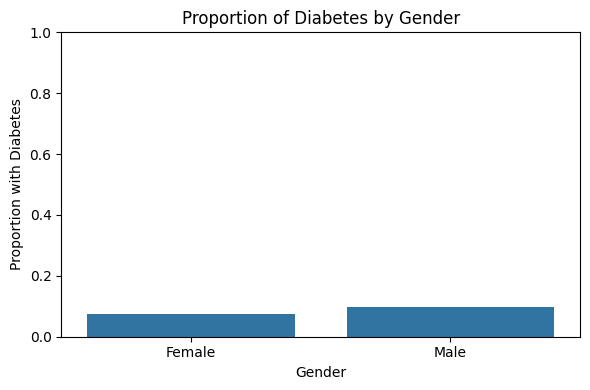

In [50]:
gender_diabetes_rate = df.groupby('gender_Male')['diabetes'].mean().reset_index()

# Plot as bar plot
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
sns.barplot(x='gender_Male', y='diabetes', data=gender_diabetes_rate)
plt.title('Proportion of Diabetes by Gender')
plt.xlabel('Gender')
plt.ylabel('Proportion with Diabetes')
plt.ylim(0, 1)
plt.xticks([0, 1], ['Female', 'Male'])  # Better labels
plt.tight_layout()
plt.show()

In this boxplot while Males have a slightly higher rate of being diagnosed with diabetes, there is little difference between Male and Females. This gives me evidence to beleive that male vs female will not have much effect on our model and will not be a very important feature. 

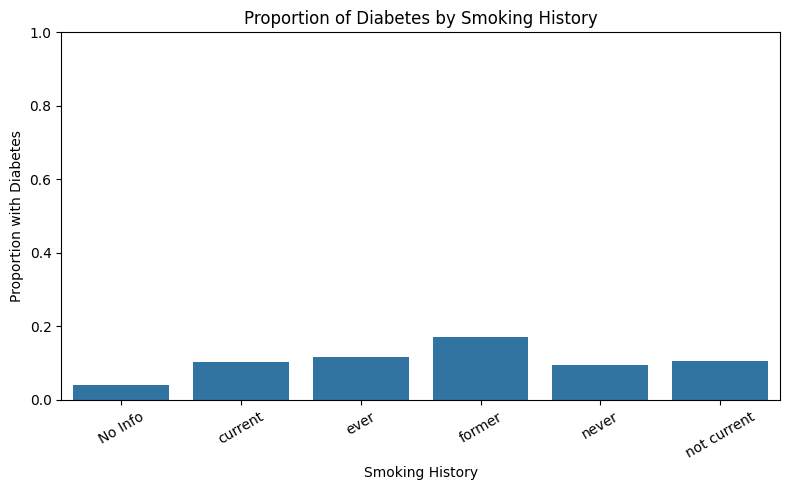

In [51]:
# Calculate proportion of diabetes in each smoking category
smoking_diabetes_rate = df.groupby('smoking_history')['diabetes'].mean().reset_index()

# Plot the results
plt.figure(figsize=(8, 5))
sns.barplot(x='smoking_history', y='diabetes', data=smoking_diabetes_rate)
plt.title('Proportion of Diabetes by Smoking History')
plt.xlabel('Smoking History')
plt.ylabel('Proportion with Diabetes')
plt.ylim(0, 1)
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

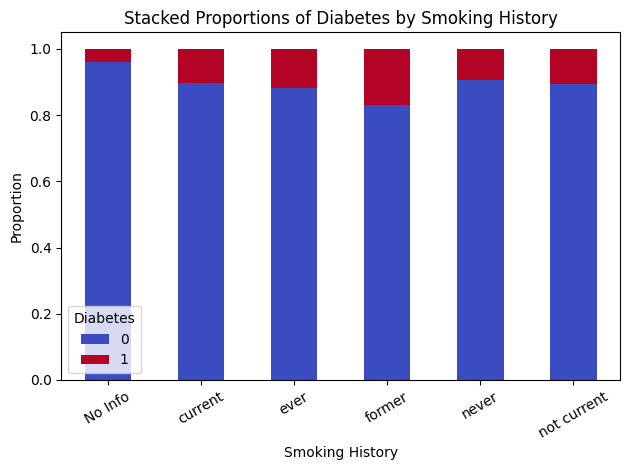

In [52]:
smoking_crosstab = pd.crosstab(df['smoking_history'], df['diabetes'], normalize='index')
smoking_crosstab.plot(kind='bar', stacked=True, colormap='coolwarm')
plt.title('Stacked Proportions of Diabetes by Smoking History')
plt.ylabel('Proportion')
plt.xlabel('Smoking History')
plt.legend(title='Diabetes')
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

When looking at this graph it is celar that people who were former smokers show a higher rate of diabetes than other groups, indicating that past smoking behavior might be more important than current habits.The stacked bar chart adds more context, showing how each smoking category breaks down by diabetes status. It confirms that the former group has a visibly higher portion of diabetes cases, aligning with the previous chart. 

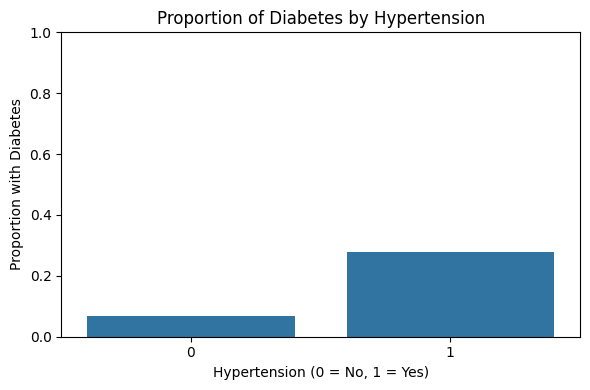

In [53]:
# Proportion of diabetes within hypertension groups
htn_rate = df.groupby('hypertension')['diabetes'].mean().reset_index()

# Plot
plt.figure(figsize=(6, 4))
sns.barplot(x='hypertension', y='diabetes', data=htn_rate)
plt.title('Proportion of Diabetes by Hypertension')
plt.xlabel('Hypertension (0 = No, 1 = Yes)')
plt.ylabel('Proportion with Diabetes')
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

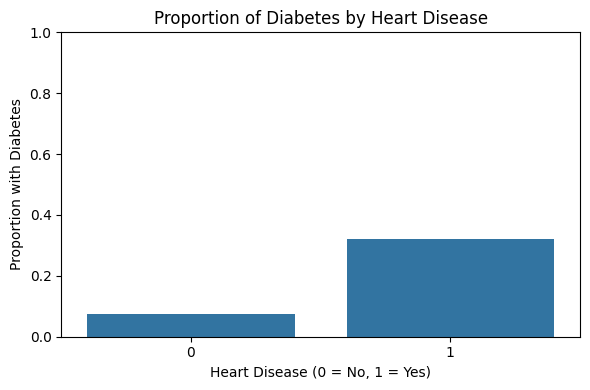

In [54]:
heart_rate = df.groupby('heart_disease')['diabetes'].mean().reset_index()

plt.figure(figsize=(6, 4))
sns.barplot(x='heart_disease', y='diabetes', data=heart_rate)
plt.title('Proportion of Diabetes by Heart Disease')
plt.xlabel('Heart Disease (0 = No, 1 = Yes)')
plt.ylabel('Proportion with Diabetes')
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

The next plots focus on hypertension and heart disease. Both show a clear increase in diabetes prevalence when these conditions are present. Individuals with heart disease or hypertension are over three times more likely to have diabetes compared to those without. These binary variables are strong indicators of potential risk and will most likely be important indicators for our model

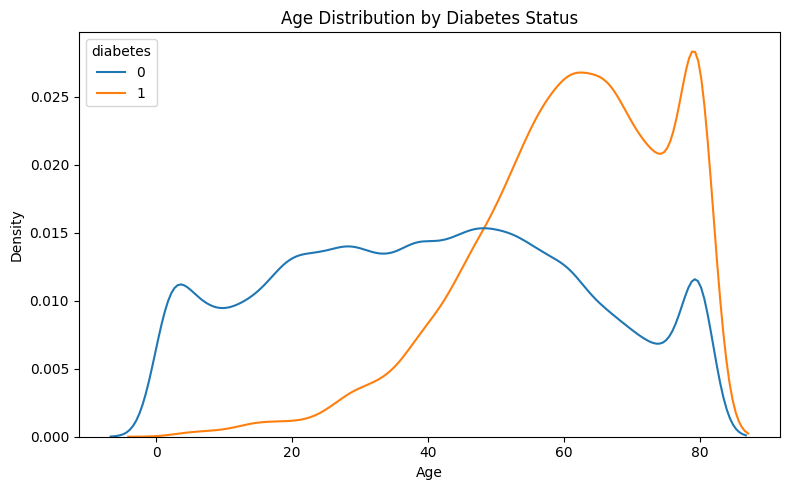

In [55]:
plt.figure(figsize=(8, 5))
sns.kdeplot(data=df, x='age', hue='diabetes', common_norm=False)
plt.title('Age Distribution by Diabetes Status')
plt.xlabel('Age')
plt.ylabel('Density')
plt.tight_layout()
plt.show()

This graph shows how age is positively correlated with diabetes. The diabetic population tends to be older, while younger individuals are more likely to be non-diabetic. This pattern supports our research that the risk of developing diabetes increases with age.

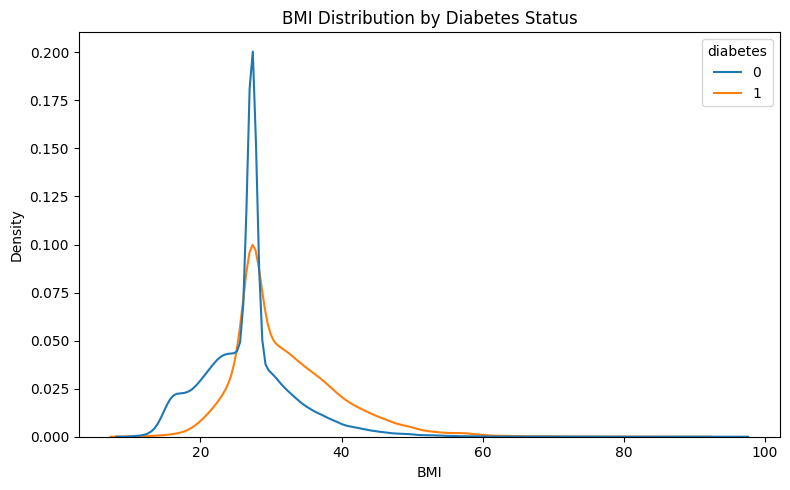

In [56]:
plt.figure(figsize=(8, 5))
sns.kdeplot(data=df, x='bmi', hue='diabetes', common_norm=False)
plt.title('BMI Distribution by Diabetes Status')
plt.xlabel('BMI')
plt.ylabel('Density')
plt.tight_layout()
plt.show()

While both groups share similar median BMI values, individuals with diabetes exhibit more variance and a slight shift toward higher BMI values. This suggests a potential, though not dominant, relationship between higher BMI and diabetes risk.

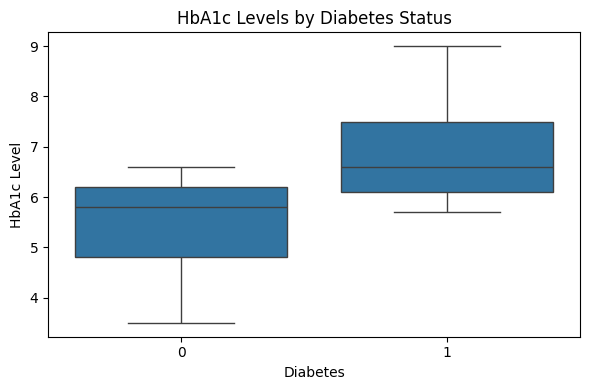

In [57]:
plt.figure(figsize=(6, 4))
sns.boxplot(x='diabetes', y='HbA1c_level', data=df)
plt.title('HbA1c Levels by Diabetes Status')
plt.xlabel('Diabetes')
plt.ylabel('HbA1c Level')
plt.tight_layout()
plt.show()


There is a strong positive association between elevated HbA1c levels and diabetes. Individuals diagnosed with diabetes tend to have significantly higher HbA1c levels, which aligns with research that we have done about HbA1c levels and diabetes. This makes it a reliable indicator for distinguishing diabetic status and will be important to our model

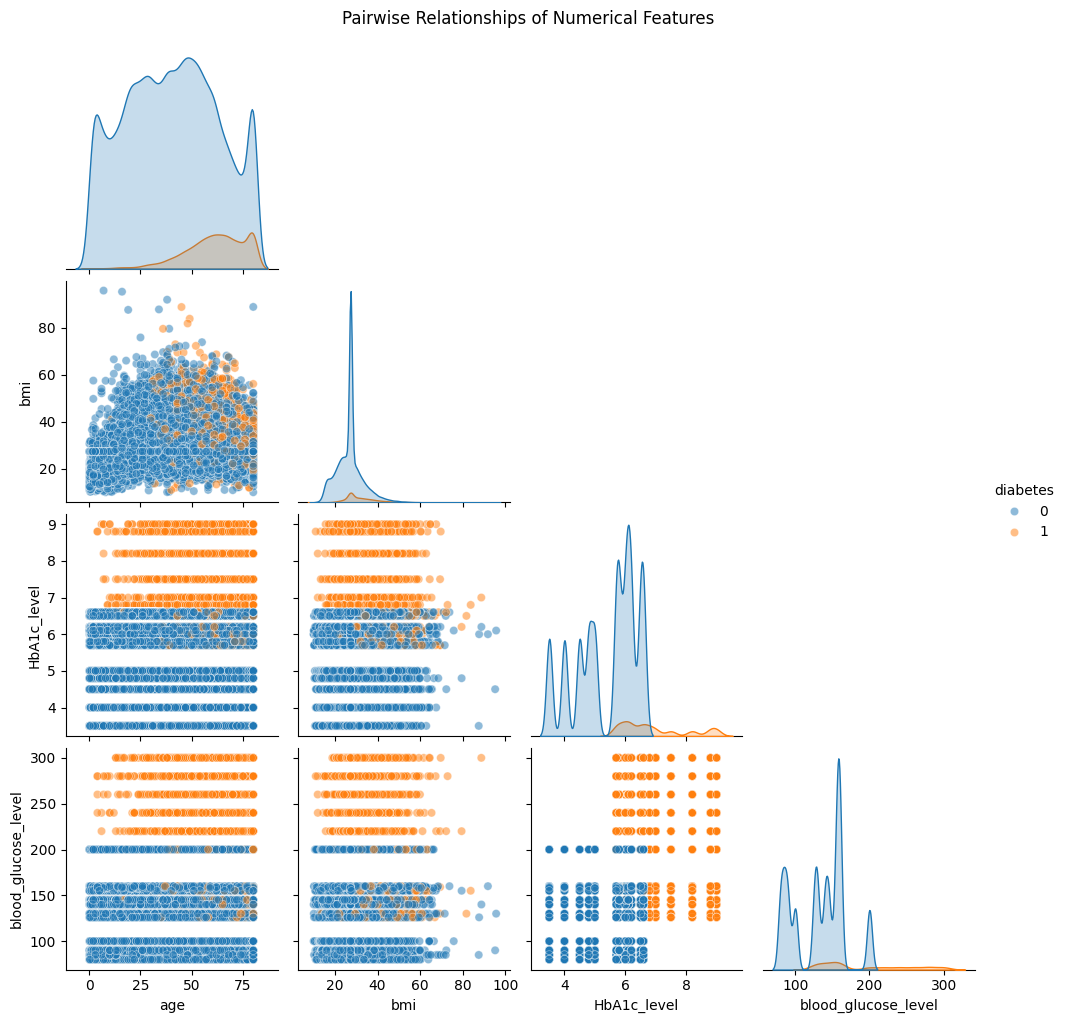

In [58]:
sns.pairplot(df, vars=['age', 'bmi', 'HbA1c_level', 'blood_glucose_level'], hue='diabetes', corner=True, plot_kws={'alpha':0.5})
plt.suptitle('Pairwise Relationships of Numerical Features', y=1.02)
plt.show()

The pairplot allows us to see how multiple features interact. It shows that diabetes cases (orange) cluster in areas with higher age, HbA1c, and blood glucose levels. This confirms what we’ve seen in the individual charts and highlights how looking at these variables togehter can paint a clear picutre on the likelyhood of somone having diabetes. 

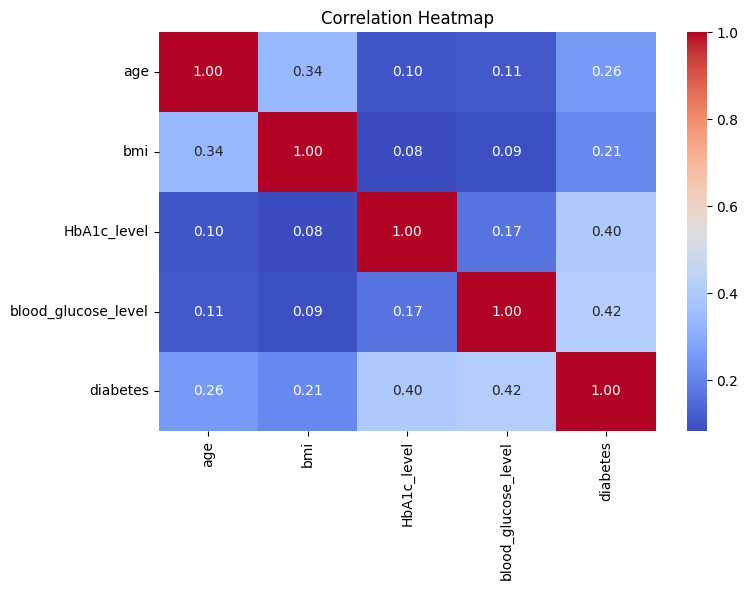

In [59]:
corr_matrix = df[numerical_vars + [target_var]].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()

The heatmap provides a summary of all pairwise correlations. HbA1c_level and blood_glucose_level show the strongest relationships with diabetes, followed by age and bmi. While none of the correlations are extremely strong, the patterns still align with the trends we saw in the visualizations and help identify  features that will be important to our models. The relatively weak correlations could be due to the binary nature of the diabetes variable, which limits how strongly it can linearly correlate with continuous features.

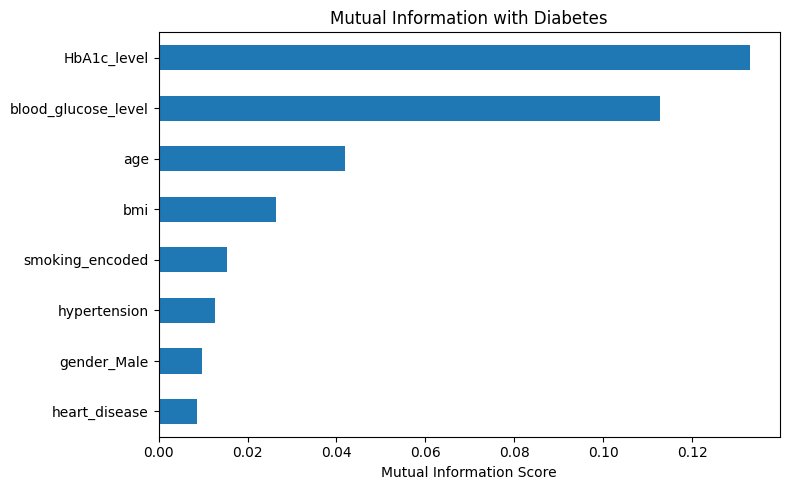

In [60]:
feature_cols = ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level',
                'hypertension', 'heart_disease', 'smoking_encoded', 'gender_Male']
X = df[feature_cols]
y = df['diabetes']

# Calculate Mutual Information
from sklearn.feature_selection import mutual_info_classif
import matplotlib.pyplot as plt

mi_scores = mutual_info_classif(X, y, random_state=0)
mi_series = pd.Series(mi_scores, index=feature_cols).sort_values()

# Plot Mutual Information
plt.figure(figsize=(8, 5))
mi_series.plot(kind='barh', title='Mutual Information with Diabetes')
plt.xlabel('Mutual Information Score')
plt.tight_layout()
plt.show()

This chart shows how much each feature helps us predict diabetes using mutual information, which captures both linear and nonlinear relationships. The top two features again are HbA1c_level and blood glucose level confirming that they carry the most predictive power for diabetes in this dataset. Age and bmi follow indicating they still contribute useful information, just not as strongly.  Altogether, the analysis highlights that medical metrics like HbA1c level and blood glucose level are the most informative features when predicting diabetes

### Data Analytics

This project uses a supervised learning approach because the goal is to predict a known outcome: whether or not an individual has diabetes. Supervised learning is appropriate when the target variable is labeled, which is the case here with the diabetes column containing binary values (0 for non-diabetic, 1 for diabetic). Each instance in the dataset includes both a label and a set of features, making this a classic binary classification problem.The dependent variable in this dataset is diabetes, which represents the outcome we are trying to predict. All other variables are considered independent features. These include numerical features like age, bmi, HbA1c_level, and blood_glucose_level; binary indicators like hypertension and heart_disease; and encoded categorical variables such as gender_Male and smoking_encoded. These independent variables are used as inputs to train classification models to learn patterns and relationships that can help with finding out if someone has diabetes or not.

To evaluate the performance of the classification models, we chose to look at accuracy, precision, recall, F1 score, and ROC AUC. Accuracy provides a general sense of how often the model predicts correctly, while precision focuses on reducing false positives, which is useful when misclassifying healthy individuals. Recall is particularly critical in healthcare applications, where failing to detect someone with diabetes (a false negative) can have serious consequences. The F1 score uses both precision and recall, offering a single metric that reflects the trade off between them. Lastly, ROC AUC measures the model’s ability to rank positive cases higher than negative ones across all thresholds, making it an effective metric for overall model discrimination.

In [79]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

feature_cols = ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level',
                'hypertension', 'heart_disease', 'smoking_encoded', 'gender_Male']
X= df[feature_cols]
y = df['diabetes']


from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def evaluate_model_with_scaler(model, scaler, X, y, cv_folds=5):
    if scaler:
        pipeline = make_pipeline(scaler, model)
    else:
        pipeline = model

    cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)

    y_pred = cross_val_predict(pipeline, X, y, cv=cv, method='predict')
    y_proba = cross_val_predict(pipeline, X, y, cv=cv, method='predict_proba')[:, 1] if hasattr(model, "predict_proba") else None

    metrics = {
        "Accuracy": accuracy_score(y, y_pred),
        "Precision": precision_score(y, y_pred, zero_division=0),
        "Recall": recall_score(y, y_pred, zero_division=0),
        "F1 Score": f1_score(y, y_pred, zero_division=0),
        "ROC AUC": roc_auc_score(y, y_proba) if y_proba is not None else None
    }

    return metrics

In [ ]:
raw_models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "Naive Bayes": GaussianNB()
}

results = []

# Evaluate each model on raw data
print("Model Performance (Raw Data):")
for model_name, model in raw_models.items():
    metrics = evaluate_model_with_scaler(model, scaler=None, X=X, y=y)
    print(f"\n{model_name}:")
    results.append([
        model_name,
        "Raw",
        metrics["Accuracy"],
        metrics["Precision"],
        metrics["Recall"],
        metrics["F1 Score"],
        metrics["ROC AUC"]
    ])
    for metric, value in metrics.items():
        print(f"  {metric}: {value:.4f}")

Model Performance (Raw Data):


In [ ]:
scaledModels = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "Naive Bayes": GaussianNB()
}

# Evaluate each model on raw data
print("Model Performance Standard Scaler:")
for model_name, model in scaledModels.items():
    metrics = evaluate_model_with_scaler(model, scaler=StandardScaler(), X=X, y=y)
    print(f"\n{model_name}:")
    results.append([
        model_name,
        "Standard Scaler",
        metrics["Accuracy"],
        metrics["Precision"],
        metrics["Recall"],
        metrics["F1 Score"],
        metrics["ROC AUC"]
    ])
    for metric, value in metrics.items():
        print(f"  {metric}: {value:.4f}")

Model Performance Standard Scaler:

Logistic Regression:
  Accuracy: 0.9602
  Precision: 0.8672
  Recall: 0.6276
  F1 Score: 0.7282
  ROC AUC: 0.9613

Random Forest:
  Accuracy: 0.9699
  Precision: 0.9455
  Recall: 0.6854
  F1 Score: 0.7947
  ROC AUC: 0.9637

Gradient Boosting:
  Accuracy: 0.9720
  Precision: 0.9845
  Recall: 0.6812
  F1 Score: 0.8052
  ROC AUC: 0.9791

Naive Bayes:
  Accuracy: 0.9034
  Precision: 0.4523
  Recall: 0.6478
  F1 Score: 0.5326
  ROC AUC: 0.9222


In [ ]:
normalizedModels = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "Naive Bayes": GaussianNB()
}

# Evaluate each model on raw data
print("Model Performance Normalized Data:")
for model_name, model in scaledModels.items():
    metrics = evaluate_model_with_scaler(model, scaler=Normalizer(), X=X, y=y)
    print(f"\n{model_name}:")
    results.append([
        model_name,
        "Normalized",
        metrics["Accuracy"],
        metrics["Precision"],
        metrics["Recall"],
        metrics["F1 Score"],
        metrics["ROC AUC"]
    ])
    for metric, value in metrics.items():
        print(f"  {metric}: {value:.4f}")

Model Performance Normalized Data:

Logistic Regression:
  Accuracy: 0.9150
  Precision: 0.0000
  Recall: 0.0000
  F1 Score: 0.0000
  ROC AUC: 0.7446

Random Forest:
  Accuracy: 0.9555
  Precision: 0.8984
  Recall: 0.5366
  F1 Score: 0.6719
  ROC AUC: 0.9392

Gradient Boosting:
  Accuracy: 0.9486
  Precision: 0.9508
  Recall: 0.4164
  F1 Score: 0.5791
  ROC AUC: 0.9324

Naive Bayes:
  Accuracy: 0.8791
  Precision: 0.2892
  Recall: 0.2895
  F1 Score: 0.2894
  ROC AUC: 0.7793


In [ ]:
robustModels = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "Naive Bayes": GaussianNB()
}

# Evaluate each model on raw data
print("Model Performance Robust scaler:")
for model_name, model in scaledModels.items():
    metrics = evaluate_model_with_scaler(model, scaler=RobustScaler(), X=X, y=y)
    print(f"\n{model_name}:")
    results.append([
        model_name,
        "Robust",
        metrics["Accuracy"],
        metrics["Precision"],
        metrics["Recall"],
        metrics["F1 Score"],
        metrics["ROC AUC"]
    ])
    for metric, value in metrics.items():
        print(f"  {metric}: {value:.4f}")

Model Performance Robust scaler:

Logistic Regression:
  Accuracy: 0.9602
  Precision: 0.8681
  Recall: 0.6272
  F1 Score: 0.7282
  ROC AUC: 0.9613

Random Forest:
  Accuracy: 0.9699
  Precision: 0.9452
  Recall: 0.6858
  F1 Score: 0.7948
  ROC AUC: 0.9636

Gradient Boosting:
  Accuracy: 0.9720
  Precision: 0.9845
  Recall: 0.6812
  F1 Score: 0.8052
  ROC AUC: 0.9791

Naive Bayes:
  Accuracy: 0.9034
  Precision: 0.4523
  Recall: 0.6478
  F1 Score: 0.5326
  ROC AUC: 0.9222


In [ ]:
feature_df = df[['age',
'bmi', 
'HbA1c_level',
'blood_glucose_level',
'hypertension',
'heart_disease',
'smoking_encoded',
'gender_Male']]

In [ ]:
scaler = StandardScaler()

scaled_data = scaler.fit_transform(feature_df)

scaled_df = pd.DataFrame(scaled_data, columns=feature_df.columns)
scaled_df

,age,bmi,HbA1c_level,blood_glucose_level,hypertension,heart_disease,smoking_encoded,gender_Male
0,1.692704,-0.321056,1.001706,0.047704,-0.284439,4.936379,0.963327,-0.841046
1,0.538006,-0.000116,1.001706,-1.426210,-0.284439,-0.202578,-1.153468,-0.841046
2,-0.616691,-0.000116,0.161108,0.489878,-0.284439,-0.202578,0.963327,1.188995
3,-0.261399,-0.583232,-0.492690,0.416183,-0.284439,-0.202578,-0.624269,-0.841046
4,1.515058,-1.081970,-0.679490,0.416183,3.515687,4.936379,-0.624269,1.188995
...,...,...,...,...,...,...,...,...
99995,1.692704,-0.000116,0.628107,-1.180558,-0.284439,-0.202578,-1.153468,-0.841046
99996,-1.771388,-1.499343,0.908306,-0.934905,-0.284439,-0.202578,-1.153468,-0.841046
99997,1.070944,0.076729,0.161108,0.416183,-0.284439,-0.202578,0.434128,1.188995
99998,-0.794336,1.220361,-1.426688,-0.934905,-0.284439,-0.202578,0.963327,-0.841046


In [ ]:
normalizer = Normalizer()

normal_data = normalizer.fit_transform(scaled_df)

normalized_df = pd.DataFrame(normal_data, columns=scaled_df.columns)

In [ ]:
normalizedModels = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    #"SVM (RBF Kernel)": SVC(probability=True, random_state=42),
    "Naive Bayes": GaussianNB()
}

# Evaluate each model on raw data
print("Model Performance Normalized Data:")
for model_name, model in scaledModels.items():
    metrics = evaluate_model_with_scaler(model, scaler=Normalizer(), X=X, y=y)
    print(f"\n{model_name}:")
    results.append([
        model_name,
        "Normalized+Scaled",
        metrics["Accuracy"],
        metrics["Precision"],
        metrics["Recall"],
        metrics["F1 Score"],
        metrics["ROC AUC"]
    ])
    for metric, value in metrics.items():
        print(f"  {metric}: {value:.4f}")

performance_df = pd.DataFrame(results, columns=[
    "Model", "Data Version", "Accuracy", "Precision", "Recall", "F1 Score", "ROC AUC"
])

Model Performance Normalized Data:

Logistic Regression:
  Accuracy: 0.9150
  Precision: 0.0000
  Recall: 0.0000
  F1 Score: 0.0000
  ROC AUC: 0.7446

Random Forest:
  Accuracy: 0.9555
  Precision: 0.8984
  Recall: 0.5366
  F1 Score: 0.6719
  ROC AUC: 0.9392

Gradient Boosting:
  Accuracy: 0.9486
  Precision: 0.9508
  Recall: 0.4164
  F1 Score: 0.5791
  ROC AUC: 0.9324

Naive Bayes:
  Accuracy: 0.8791
  Precision: 0.2892
  Recall: 0.2895
  F1 Score: 0.2894
  ROC AUC: 0.7793


After running all of our models using different preprocessing methods, we noticed that Gradient Boosting and Random Forest consistently performed the best when it came to predicting diabetes. Gradient Boosting stood out in particular, giving us the highest scores across accuracy, F1, and ROC AUC almost every time. Random Forest was also very reliable and showed strong results no matter which data preparation technique we used. This showed us how powerful these tree-based models can be, especially when working with a dataset that includes a mix of numerical and categorical features.

We also saw that models like Logistic Regression needed more careful preprocessing to work well. Their results changed depending on how we scaled the data. One thing that stood out was how much worse these models performed when we used the Normalizer. In a few cases, like with Logistic Regression, the model had zero precision and recall, which made it completely ineffective. This helped us realize that Normalizer is not always the best choice, especially for models that rely on clear feature relationships. Instead of helping, it seemed to distort the data in ways that caused the models to miss important patterns.

Naive Bayes struggled the most overall. While it sometimes had okay accuracy, it had trouble balancing precision and recall. This makes sense because Naive Bayes assumes that all features are independent, which we know is not true for health-related data like this.

Another interesting thing we found was that keeping the rows labeled “No Info” actually helped performance in many cases. We expected that dropping those rows would clean up the dataset, but it turns out that even incomplete or ambiguous data can still provide useful information, especially for stronger models like Gradient Boosting.

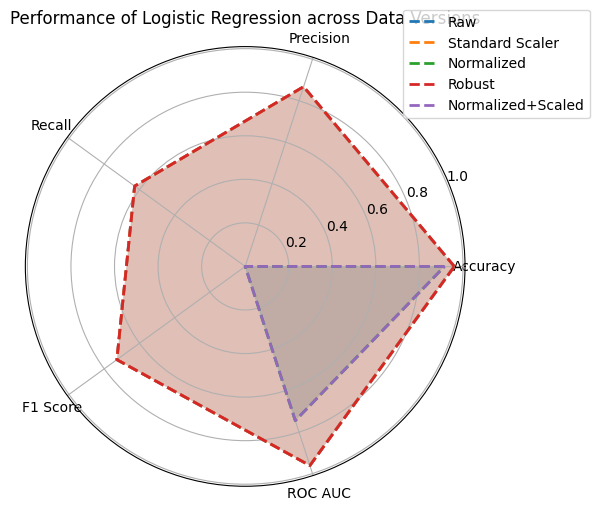

In [ ]:
model_name = "Logistic Regression"
df_subset = performance_df[performance_df["Model"] == model_name]

labels = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC']
num_vars = len(labels)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

for version in df_subset["Data Version"].unique():
    row = df_subset[df_subset["Data Version"] == version][labels].values.flatten().tolist()
    row += row[:1]
    ax.plot(angles, row, label=version, linestyle='--', linewidth=2)
    ax.fill(angles, row, alpha=0.15)


# Labeling
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels)
ax.set_title(f"Performance of {model_name} across Data Versions")
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))

plt.tight_layout()
plt.show()


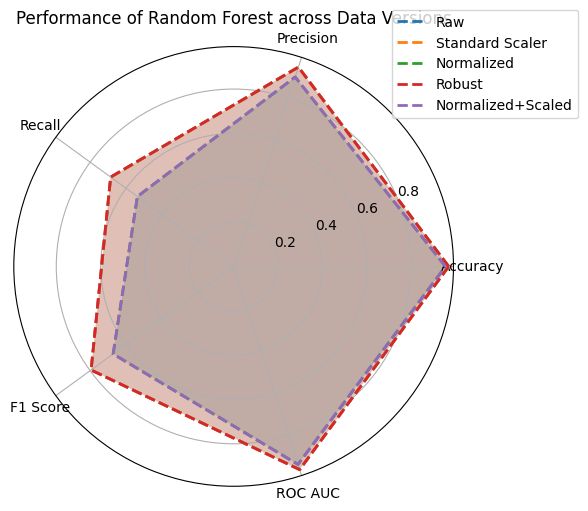

In [ ]:
model_name = "Random Forest"
df_subset = performance_df[performance_df["Model"] == model_name]

labels = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC']
num_vars = len(labels)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

for version in df_subset["Data Version"].unique():
    row = df_subset[df_subset["Data Version"] == version][labels].values.flatten().tolist()
    row += row[:1]
    ax.plot(angles, row, label=version, linestyle='--', linewidth=2)
    ax.fill(angles, row, alpha=0.15)


# Labeling
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels)
ax.set_title(f"Performance of {model_name} across Data Versions")
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))

plt.tight_layout()
plt.show()

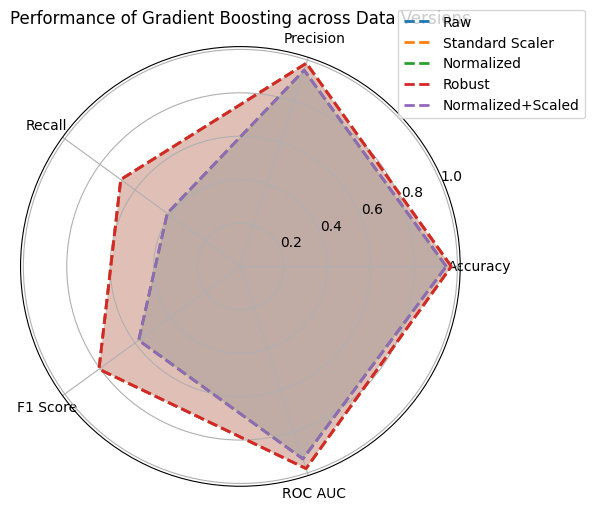

In [ ]:
model_name = "Gradient Boosting"
df_subset = performance_df[performance_df["Model"] == model_name]

labels = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC']
num_vars = len(labels)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

for version in df_subset["Data Version"].unique():
    row = df_subset[df_subset["Data Version"] == version][labels].values.flatten().tolist()
    row += row[:1]
    ax.plot(angles, row, label=version, linestyle='--', linewidth=2)
    ax.fill(angles, row, alpha=0.15)


# Labeling
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels)
ax.set_title(f"Performance of {model_name} across Data Versions")
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))

plt.tight_layout()
plt.show()

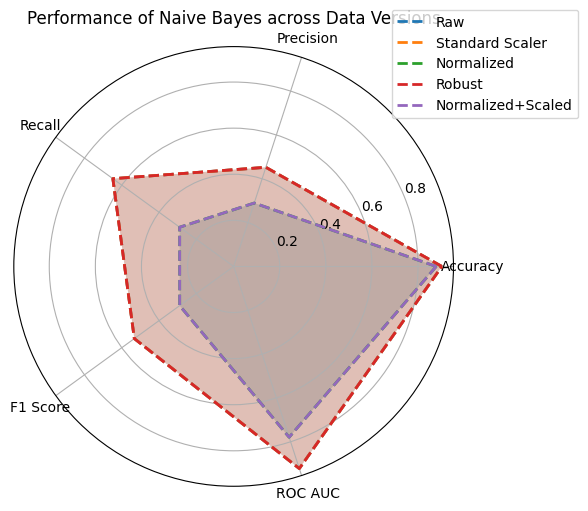

In [ ]:
model_name = "Naive Bayes"
df_subset = performance_df[performance_df["Model"] == model_name]

labels = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC']
num_vars = len(labels)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

for version in df_subset["Data Version"].unique():
    row = df_subset[df_subset["Data Version"] == version][labels].values.flatten().tolist()
    row += row[:1]
    ax.plot(angles, row, label=version, linestyle='--', linewidth=2)
    ax.fill(angles, row, alpha=0.15)


# Labeling
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels)
ax.set_title(f"Performance of {model_name} across Data Versions")
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))

plt.tight_layout()
plt.show()

These radar plots make it clear that Gradient Boosting and Random Forest are not just the most accurate models, but also the most stable and flexible ones in our analysis. They are less affected by the preprocessing method and still manage to maintain strong performance across all the main evaluation metrics. In contrast, simpler models like Naive Bayes and Logistic Regression struggle more with consistency and are more sensitive to how we prepare the data. This can be seen with the large differences between each line, whereas Random Forest and Gradient Boosting does not have much change per line and has many overlapping lines showing not only how high preforming it is but how consistent it is across data preprocessing techniques. Though we don't see what data version is the best to use as we have raw, standard scaler, and robust all on top of each other since their scores are so similar.

Empty DataFrame
Columns: [Data Version, Metric, Value]
Index: []


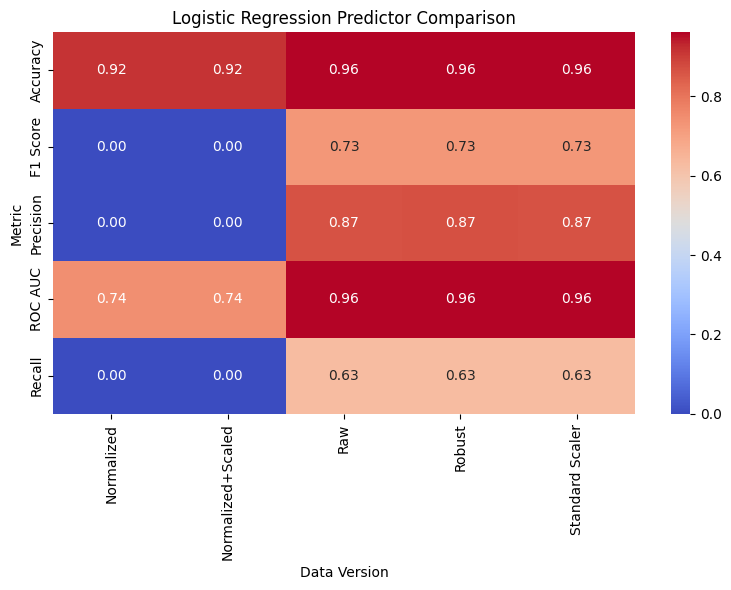

In [ ]:
subset = performance_df[performance_df["Model"] == "Logistic Regression"]
metric_cols = ["Accuracy", "Precision", "Recall", "F1 Score", "ROC AUC"]

heat_data = subset.melt(
    id_vars=["Data Version"],
    value_vars=metric_cols,
    var_name="Metric",
    value_name="Value"
)

heat_data_grouped = heat_data.groupby(["Metric", "Data Version"], as_index=False).mean()

pivot_data = heat_data_grouped.pivot(index="Metric", columns="Data Version", values="Value")


plt.figure(figsize=(8, 6))
sns.heatmap(pivot_data, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Logistic Regression Predictor Comparison")
plt.ylabel("Metric")
plt.xlabel("Data Version")
plt.tight_layout()
plt.show()

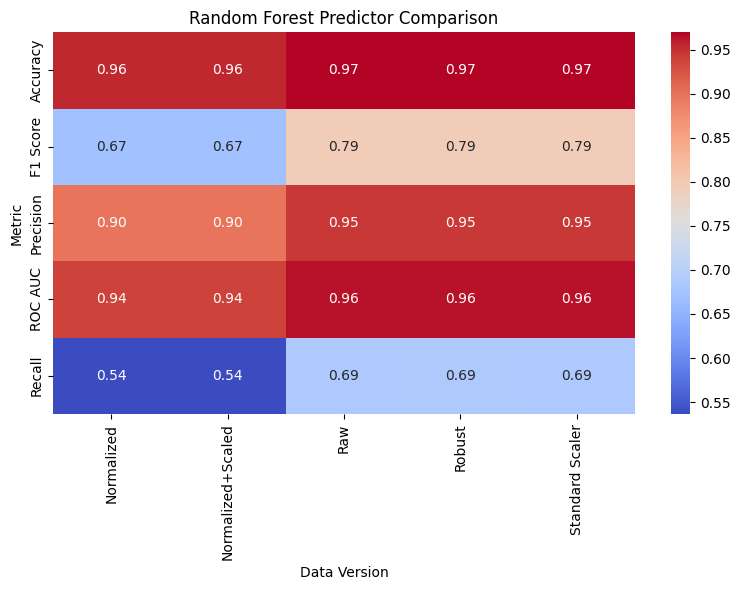

In [ ]:
subset = performance_df[performance_df["Model"] == "Random Forest"]
metric_cols = ["Accuracy", "Precision", "Recall", "F1 Score", "ROC AUC"]

heat_data = subset.melt(
    id_vars=["Data Version"],
    value_vars=metric_cols,
    var_name="Metric",
    value_name="Value"
)

heat_data_grouped = heat_data.groupby(["Metric", "Data Version"], as_index=False).mean()

pivot_data = heat_data_grouped.pivot(index="Metric", columns="Data Version", values="Value")


plt.figure(figsize=(8, 6))
sns.heatmap(pivot_data, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Random Forest Predictor Comparison")
plt.ylabel("Metric")
plt.xlabel("Data Version")
plt.tight_layout()
plt.show()

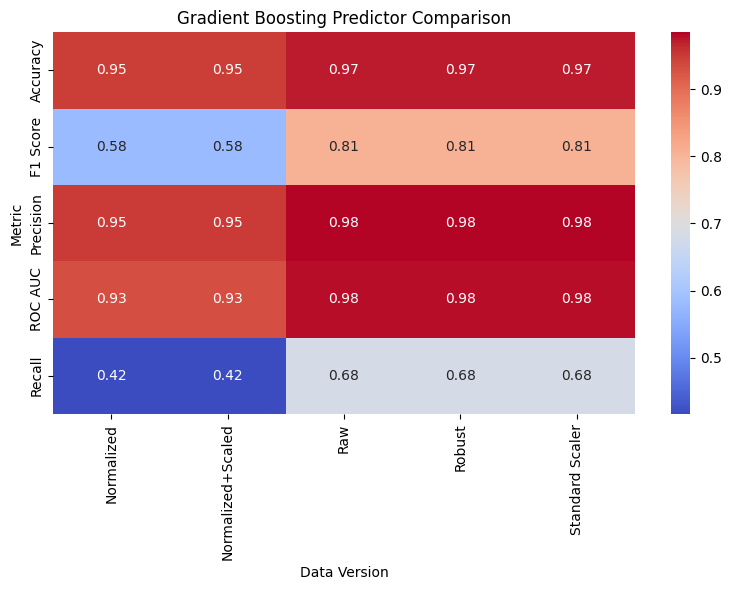

In [ ]:
subset = performance_df[performance_df["Model"] == "Gradient Boosting"]
metric_cols = ["Accuracy", "Precision", "Recall", "F1 Score", "ROC AUC"]

heat_data = subset.melt(
    id_vars=["Data Version"],
    value_vars=metric_cols,
    var_name="Metric",
    value_name="Value"
)

heat_data_grouped = heat_data.groupby(["Metric", "Data Version"], as_index=False).mean()

pivot_data = heat_data_grouped.pivot(index="Metric", columns="Data Version", values="Value")


plt.figure(figsize=(8, 6))
sns.heatmap(pivot_data, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Gradient Boosting Predictor Comparison")
plt.ylabel("Metric")
plt.xlabel("Data Version")
plt.tight_layout()
plt.show()

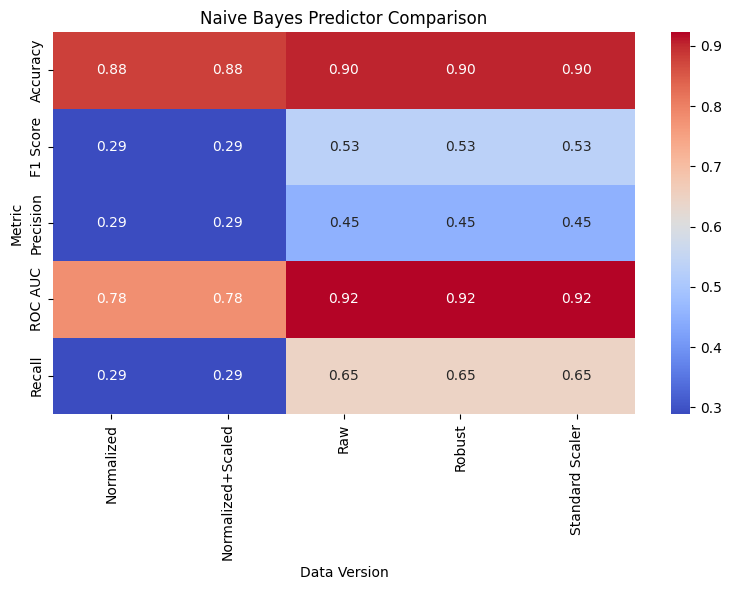

In [ ]:
subset = performance_df[performance_df["Model"] == "Naive Bayes"]
metric_cols = ["Accuracy", "Precision", "Recall", "F1 Score", "ROC AUC"]

heat_data = subset.melt(
    id_vars=["Data Version"],
    value_vars=metric_cols,
    var_name="Metric",
    value_name="Value"
)

heat_data_grouped = heat_data.groupby(["Metric", "Data Version"], as_index=False).mean()

pivot_data = heat_data_grouped.pivot(index="Metric", columns="Data Version", values="Value")


plt.figure(figsize=(8, 6))
sns.heatmap(pivot_data, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Naive Bayes Predictor Comparison")
plt.ylabel("Metric")
plt.xlabel("Data Version")
plt.tight_layout()
plt.show()

When we look at the heatmaps side by side, we can clearly see that Gradient Boosting and Random Forest consistently perform the best across all metrics, regardless of how the data was scaled. Both models maintain high accuracy, precision, recall, and F1 scores, which shows they are not only accurate but also robust to different preprocessing methods. Gradient Boosting, in particular, stays strong across all versions of the data, especially in recall and F1, which are important for detecting actual diabetes cases. This final vizuliation really brings home how gradient boosted and random forets are our best algorithms. 

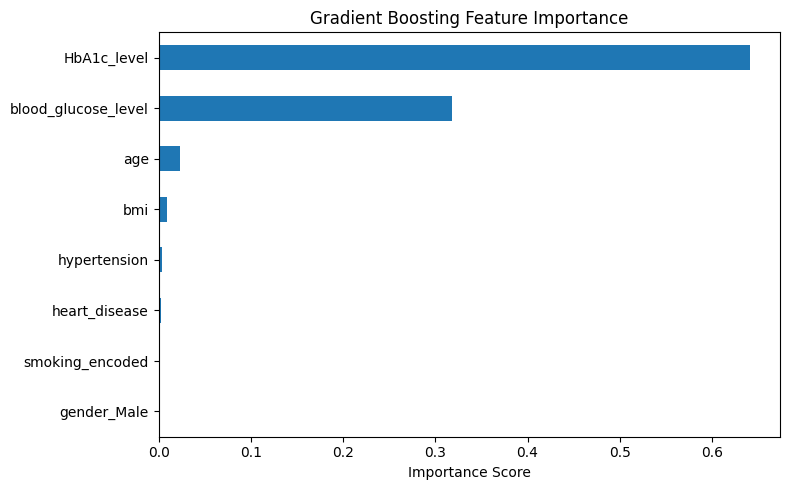

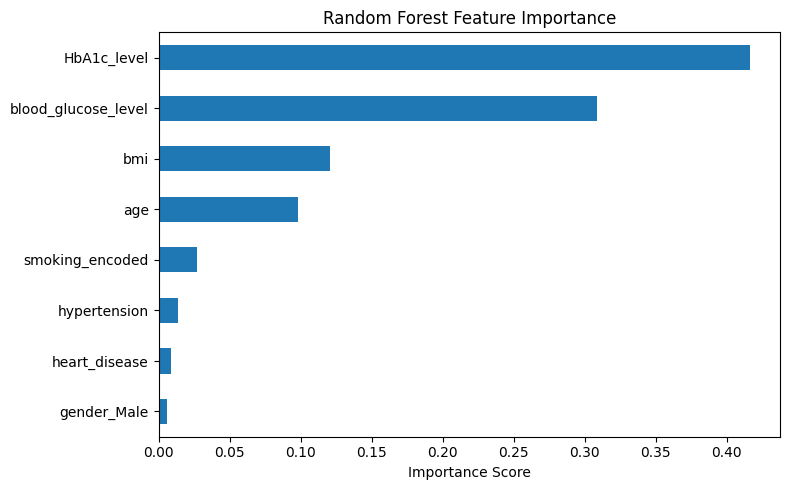

In [ ]:

# Train model
model = GradientBoostingClassifier(random_state=42)
model.fit(X, y)

# Get feature importances
feature_importance = pd.Series(model.feature_importances_, index=feature_cols).sort_values()

# Plot Feature Importance
plt.figure(figsize=(8, 5))
feature_importance.plot(kind='barh', title='Gradient Boosting Feature Importance')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()


# Train model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X, y)

# Get feature importances
rf_importance = pd.Series(rf_model.feature_importances_, index=feature_cols).sort_values()

# Plot Feature Importance
plt.figure(figsize=(8, 5))
rf_importance.plot(kind='barh', title='Random Forest Feature Importance')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()

In both models, HbA1c level is by far the most important feature. This makes perfect sense because HbA1c as we could see this correlation in the graphs above. In Gradient Boosting, it accounts for more than 60% of the total importance, and in Random Forest, it is still the top contributor at over 40%.

Blood_glucose_level is the second most important feature in both models. Like HbA1c, this is also a key biomarker in diabetes diagnosis and management. Together, these two features dominate the predictions, which confirms that the models are learning the medically relevant patterns we would expect. This males sense as both of these features show strong corrleation to diabetes in our data vizulations above